# **Trabajo Final**: "Diferenciación automática vs. diferencias finitas"
---
##*Redes Neuronales Informadas pro Física*                                   
##*Facultad de Ingeniería de la Universidad de Buenos Aires*                                                 
##*David Canal*, Alán Pérez Winter
##*Diciembre 2024*

# **1. Consigna de Trabajo**
---
# **Parte 1:** "Problema lineal"

Resolver las ecuaciones:
$$
\begin{align}
\Delta u &= \sin{\pi x}\sin{\pi y}\,,\quad 0< x <1 \quad 0< y <1\,, \tag{1a}\\
u(0, y) &= u(1, y) = 0\,, \tag{1b}\\
u(x, 0) &= u(x, 1) = 0\,, \tag{1c}
\end{align}
$$
mediante PINN y mediante el método de diferencias finitas en grillas de tamaño:
- 5 x 5 usar una red neuronal [2, 3, 3, 1]
- 10 x 10 usar una red neuronal [2, 5, 5, 1]
- 20 x 20 usar una red neuronal [2, 10, 10, 1]
Comparar ambas soluciones con la solución exacta dada por:
$$
\begin{equation}
u(x, y) = -\dfrac{1}{2\pi^2}\sin{\pi x}\sin{\pi y}
\end{equation}
$$
¿Qué solución es más precisa? ¿Por qué? Repita el experimento utilizando otras arquitecturas.

# **Parte 2:** "Problema no lineal"

Resolver el problema de conducción de calor con término fuente no lineal dado por:
$$
\begin{align}
\Delta u &= 0,5e^u,\quad 0< x <1 \quad 0< y <1\,, \tag{2a}\\
u(0, y) &= u(x, 0) = 0\,; \tag{2b}\\
\frac{\partial u(1, y)}{\partial x} &= \frac{\partial u(x, 1)}{\partial x} = 0\,; \tag{2c}
\end{align}
$$
mediante PINN y mediante el método de diferencias finitas en grillas de tamaño:
- 5 x 5 usar una red neuronal [2, 5, 5, 1]
- 10 x 10 usar una red neuronal [2, 5, 5, 1]
- 20 x 20 usar una red neuronal [2, 5, 5, 1]

Analice y discuta los resultados. repita el proceso, pero utilizando muestreos aleatorios de los puntos de colocación con la misma cantidad de muestras que en el caso de las grillas uniforme. ¿Que observa?.

# **2. Resolución**
---

# **Punto (a)**
---

# **1. Resolución mediante Diferencias Finitas**
Vamos a resolver el problema de diferencias finitas usando Python con las librerías más comunes para este tipo de problemas, como `numpy` y `matplotlib`.

El enfoque será:
1. Discretizar la ecuación de Poisson en una grilla.
2. Implementar las condiciones de contorno.
3. Resolver el sistema de ecuaciones resultante.

Voy a implementar el código para el caso de una grilla de tamaño \( 5 \times 5 \).

Se muestran las soluciones obtenidas:

1. **Solución Numérica (Diferencias Finitas):** Resolvimos el sistema de ecuaciones con una grilla \( 5 \times 5 \), y la solución aproximada se presenta como un mapa de contorno.

2. **Solución Exacta:** Se graficó para comparar visualmente con la solución numérica.

Para mejorar la precisión:
- Puedes incrementar la resolución de la grilla (usar \( 10 \times 10 \) o \( 20 \times 20 \)).
- Implementar el método PINN para resolver este problema con una red neuronal, lo cual podemos abordar a continuación. ¿Quieres que sigamos con esa parte?

## **1.1 Sistema matricial que representa el problema**

Para resolver el problema numéricamente con diferencias finitas, primero se discretiza el dominio en ${N_x} + 1$ y ${N_y} + 1$ intervalors en los ejes x e y respectivamente. Esto resulta en una grilla con ${N_x*N_y}$ puntos internos (incognitas a encontrar).

La descritización del dominio en ${N_x*N_y}$ puntos de un dominio de nodos ${(x_i,y_j)}$, con ${x_i = i/(N_x + 1)=ih_x, i = 1,...,N_x}$ y ${y_i = j/(N_y + 1)= jh_j, j = 1,...,N_y}$. Si en cada punto se utiliza aproximaciones de las derivadas segundas parciales mediante diferencias centradas de segundo orden, se obtine ${N_x*N_y}$ ecuaciones de la forma:

$$
\begin{equation}
\dfrac{u(x_i - h_x, y_j)-2u(x_i, y_j)+u(x_i + h_x, y_j)}{h_x^2} + \dfrac{u(x_i, y_j-h_y)-2u(x_i, y_j)+u(x_i, y_j+h_x)}{h_y^2} =  \sin{\pi x_i}\sin{\pi y_j}\
\end{equation}
$$
reordernando, tenemos:
$$
\begin{equation}
{h_y^2u_{(i-1,j)} + h_y^2u_{(i+1,j)} +h_x^2u_{(i,j-1)} + h_x^2u_{(i,j+1)} -2(h_x^2+h_y^2)u_{(i,j)}} =  \sin{\pi x_i}\sin{\pi y_j}\; \tag{2d}
\end{equation}
$$

donde $u_{(i,j)} = u(x_i, y_j)$. En los casosen que el punto $(x_i,y_j)$ se encuentre en uno de los bordes, se reemplaran los valores conocidos (por las condiciones de borde) en la ecuación (2d) y se reorganizan. Por ejemplo para el borde superior derecho $(N_x, N_y)$, $u_{(N_x + 1,N_y)} = 0$

In [2]:
pip install fipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 446.1/446.1 kB 5.9 MB/s eta 0:00:00


In [3]:
# Importar las librerías necesarias
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from fipy import CellVariable, Grid2D, DiffusionTerm, Viewer, Variable
from scipy.spatial import cKDTree

## **Resolución por Diferencia Finita**

In [4]:
# Parámetros del problema
u_ex     = []
u_num    = []
for nx, ny in [(5,5),(10,10),(20,20)]:
  Lx, Ly = 1.0, 1.0  # Dimensiones del dominio
  dx = Lx / nx       # Tamaño de celda en x
  dy = Ly / ny       # Tamaño de celda en y

  # Crear el dominio
  mesh = Grid2D(dx=dx, dy=dy, nx=nx, ny=ny)

  # Definir la variable de solución
  u = CellVariable(name="u", mesh=mesh, value=0.0)

  # Definir la fuente (senoidal) en el problema ∇²u = sin(πx)sin(πy)
  x, y = mesh.cellCenters

  # Change source to be a CellVariable
  source = CellVariable(name='source', mesh=mesh, value=np.sin(np.pi * x) * np.sin(np.pi * y))

  # Definir la ecuación diferencial parcial
  eq = DiffusionTerm(coeff=1.0) == source

  # Aplicar condiciones de frontera u=0 en todo el borde
  u.constrain(0.0, mesh.facesLeft)
  u.constrain(0.0, mesh.facesRight)
  u.constrain(0.0, mesh.facesBottom)
  u.constrain(0.0, mesh.facesTop)

  # Resolver la ecuación
  eq.solve(var=u)
  u_num.append(u)
  # Solución analítica para comparar: u(x, y) = -1/(2π²)sin(πx)sin(πy)
  u_ex.append(-1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y))

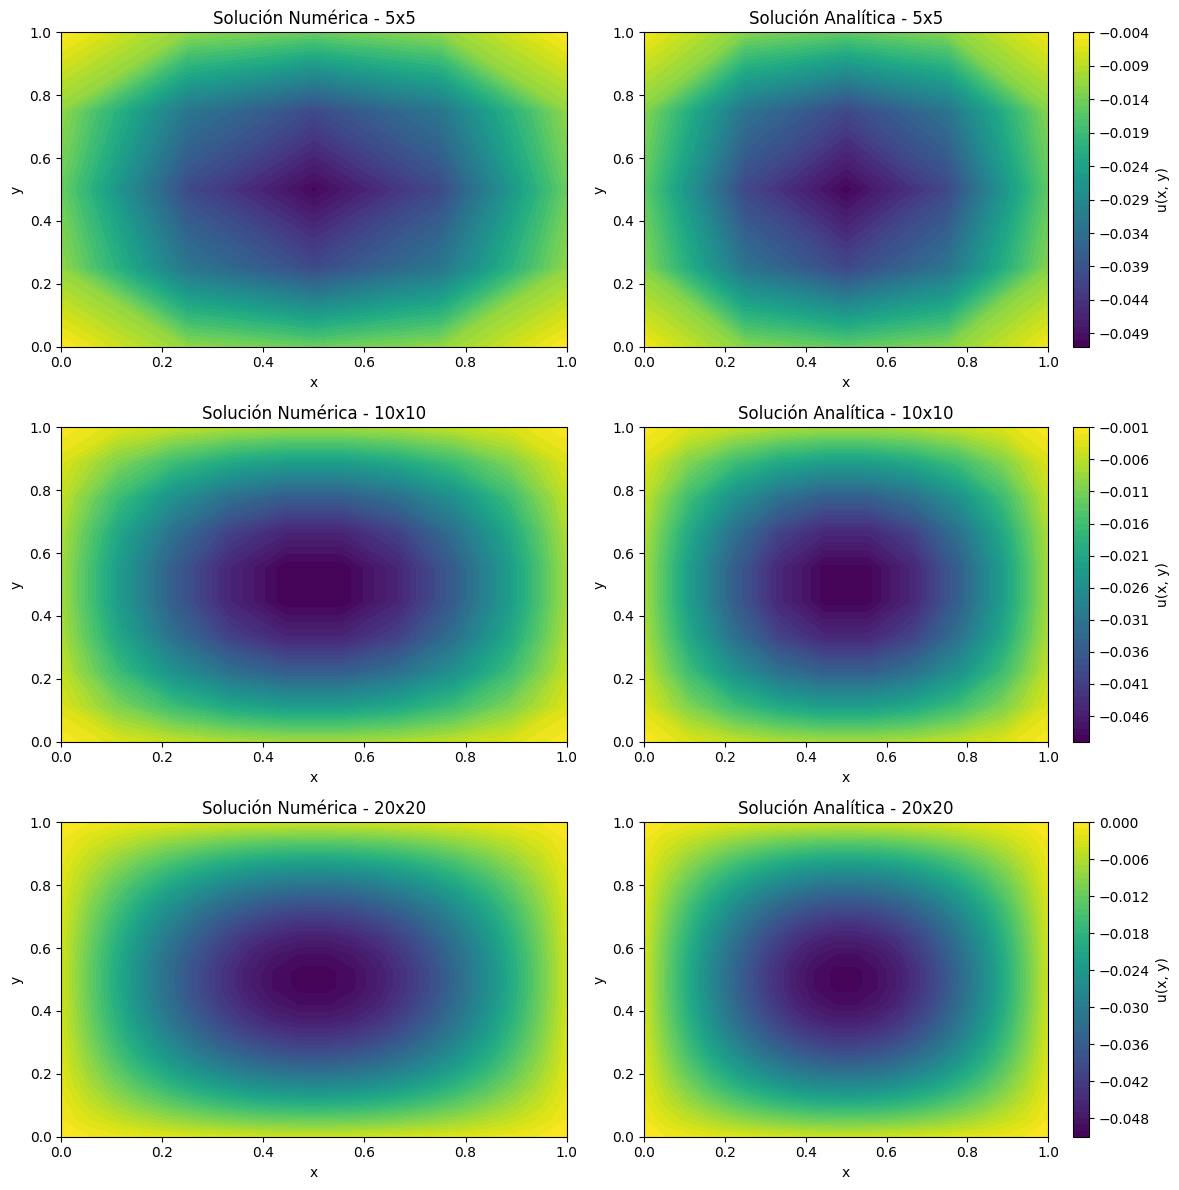

In [61]:
nx = [5, 10, 20]
ny = [5, 10, 20]

# Define Lx and Ly here as well
Lx, Ly = 1.0, 1.0

# Graficar resultados
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
k = 0
for i in range(3):
    j = 0
    # Solución numérica obtenida con FiPy
    contour = ax[i,j].contourf(
      np.reshape(u_num[k].value, (ny[k], nx[k])),
      levels=50,
      cmap="viridis",
      extent=(0, Lx, 0, Ly) # Now Lx and Ly are defined in this scope
    )
    #fig.colorbar(contour, ax=ax[i,j], label="u(x, y)")
    ax[i,j].set_title("Solución Numérica - {}x{}".format(nx[k],ny[k]))
    ax[i,j].set_xlabel("x")
    ax[i,j].set_ylabel("y")

    j += 1
    # Solución analítica
    contour = ax[i, j].contourf(
       np.reshape(u_ex[k], (ny[k], nx[k])),
      levels=50,
      cmap="viridis",
      extent=(0, Lx, 0, Ly)  # Now Lx and Ly are defined in this scope
    )
    fig.colorbar(contour, ax=ax[i,j], label="u(x, y)")
    ax[i,j].set_title("Solución Analítica - {}x{}".format(nx[k],ny[k]))
    ax[i,j].set_xlabel("x")
    ax[i,j].set_ylabel("y")

    k +=1

plt.tight_layout()
plt.show()

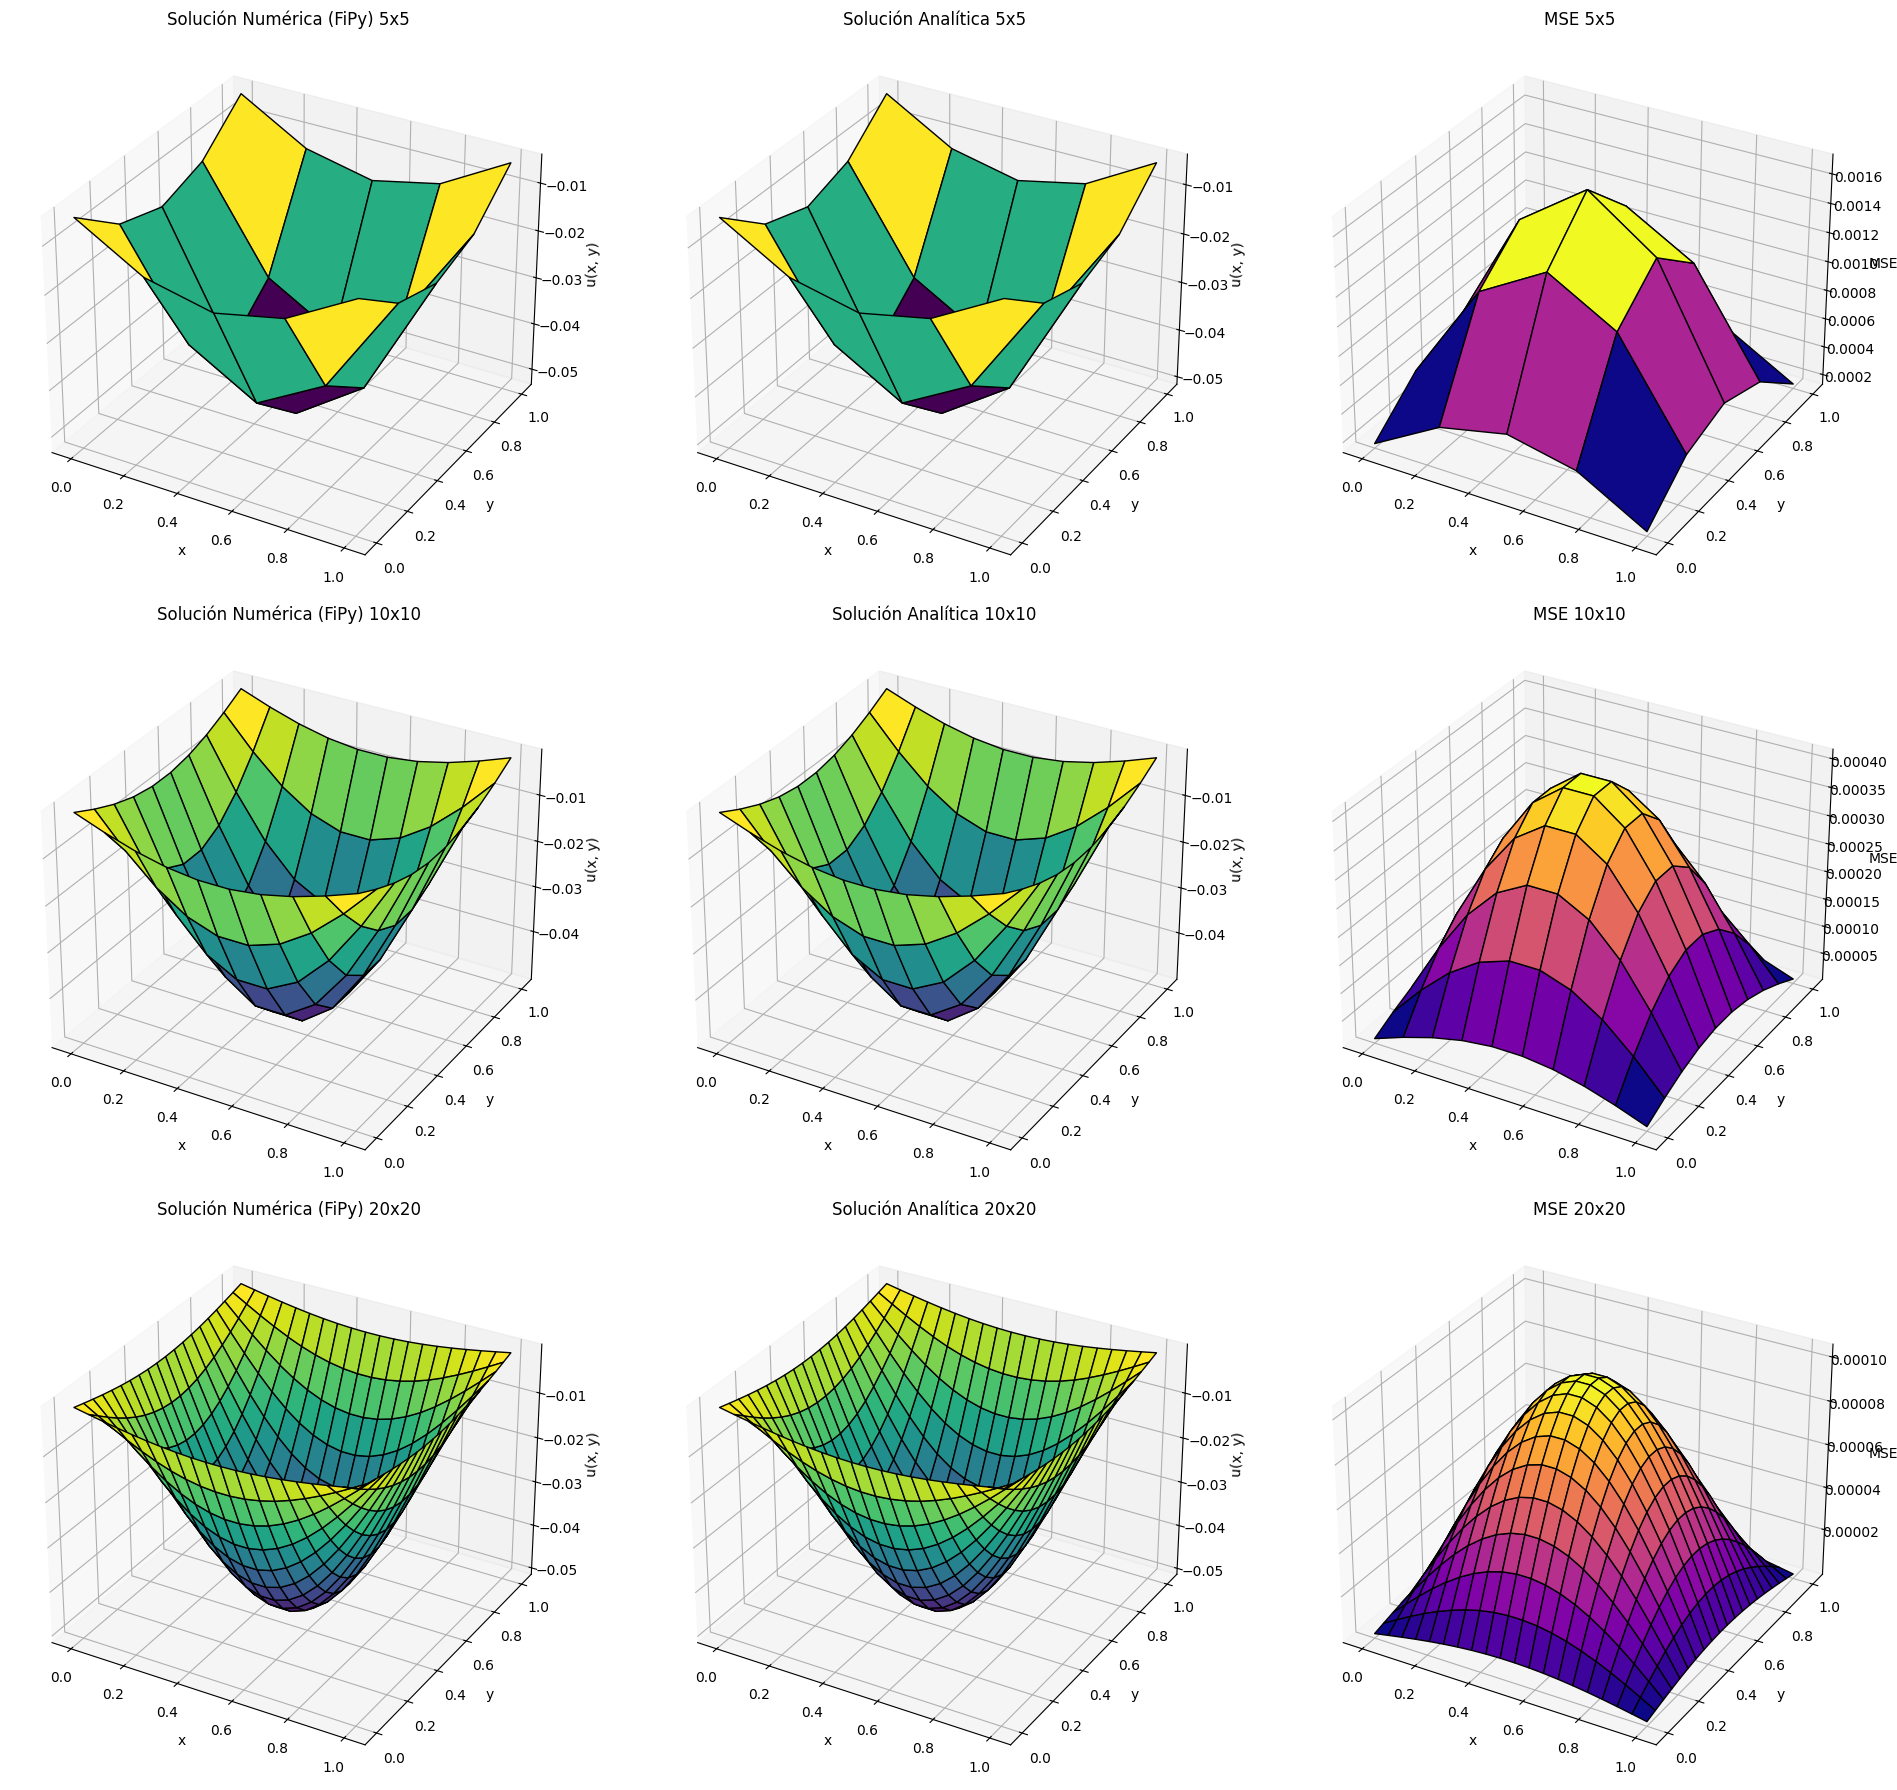

In [64]:
# Crear subgráficos para las soluciones 3D
fig = plt.figure(figsize=(20, 18))
MSE_num = []

for i in range(len(nx)):
    # Crear mallas para la grilla actual
    x_vals = np.linspace(0, Lx, nx[i])
    y_vals = np.linspace(0, Ly, ny[i])
    X, Y = np.meshgrid(x_vals, y_vals)

    # Reshape de las soluciones para gráficos 3D
    u_numeric = np.reshape(u_num[i].value, (ny[i], nx[i]))
    u_exact = np.reshape(u_ex[i], (ny[i], nx[i]))
    error_pointwise = np.sqrt((u_numeric - u_exact) ** 2)
    MSE_num.append(np.mean(error_pointwise))

    # Solución numérica (FiPy)
    ax_num = fig.add_subplot(len(nx), 3, 3 * i + 1, projection='3d')
    ax_num.plot_surface(X, Y, u_numeric, cmap='viridis', edgecolor='k')
    ax_num.set_title(f"Solución Numérica (FiPy) {nx[i]}x{ny[i]}")
    ax_num.set_xlabel("x")
    ax_num.set_ylabel("y")
    ax_num.set_zlabel("u(x, y)")

    # Solución analítica
    ax_exact = fig.add_subplot(len(nx), 3, 3 * i + 2, projection='3d') # Changed to 3 columns and adjusted index
    ax_exact.plot_surface(X, Y, u_exact, cmap='viridis', edgecolor='k')
    ax_exact.set_title(f"Solución Analítica {nx[i]}x{ny[i]}")
    ax_exact.set_xlabel("x")
    ax_exact.set_ylabel("y")
    ax_exact.set_zlabel("u(x, y)")

    # MSE punto a punto
    ax_error= fig.add_subplot(len(nx), 3, 3 * i + 3, projection='3d') # Changed to 3 columns and adjusted index
    ax_error.plot_surface(X, Y, error_pointwise, cmap='plasma', edgecolor='k')
    ax_error.set_title(f"MSE {nx[i]}x{ny[i]}")
    ax_error.set_xlabel("x")
    ax_error.set_ylabel("y")
    ax_error.set_zlabel("MSE")

plt.tight_layout()
plt.show()

## **Resolución por PINN**

In [39]:
# Actualizar función de pérdida para usar todos los puntos de la grilla
def loss_function_with_grid(model, all_points, exact_values):
    u_pred = model(all_points).squeeze()
    exact_values = torch.tensor(exact_values, dtype=torch.float32)
    loss = torch.mean((u_pred - exact_values) ** 2)
    return loss

# Definir la solución exacta
def exact_solution(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Generar puntos de colocación internos y en los bordes
def generate_points(grid_size):
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    points = np.c_[X.ravel(), Y.ravel()]

    # Identificar puntos de borde
    is_boundary = (points[:, 0] == 0) | (points[:, 0] == 1) | (points[:, 1] == 0) | (points[:, 1] == 1)
    boundary_points = points[is_boundary]
    internal_points = points[~is_boundary]

    return torch.tensor(internal_points, dtype=torch.float32), torch.tensor(boundary_points, dtype=torch.float32)

# Definir la red neuronal
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        return self.layers[-1](x)

# Residuo de la PDE
def pde_residual(model, x):
    x.requires_grad_(True)
    inputs = x
    u = model(inputs)
    u_x = torch.autograd.grad(u, x[:, 0], grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, x[:, 1], grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x[:, 0], grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, x[:, 1], grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
    return u_xx + u_yy - torch.sin(np.pi * x[:, 0]) * torch.sin(np.pi * x[:, 1])

# Función de pérdida
def loss_function(model, internal_points, boundary_points):
    # Residuo en los puntos internos
    residual = pde_residual(model, internal_points)
    loss_pde = torch.mean(residual**2)

    # Condiciones de borde
    u_boundary = model(boundary_points)
    loss_bc = torch.mean(u_boundary**2)  # Frontera u = 0

    return loss_pde + loss_bc

# Entrenar el modelo
def train_pinn(model, optimizer, n_epochs, internal_points, boundary_points):
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        loss = loss_function(model, internal_points, boundary_points)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return model

In [46]:
# Configuración del problema
grid_size = [5,10,20]
layers = [[2, 3, 3, 1],[2, 10, 10, 1],[2, 20, 20, 1]]  # Estructura de la red neuronal
n_epochs = 8000

In [99]:
# Entrenamos los modelos
u_pinn = []
loss_history = []
for i in range(len(grid_size)):
  print("________________________________________________\n")
  print("Grilla {}x{} - Configuración de {}".format(grid_size[i],grid_size[i],layers[i]))
  print("________________________________________________")

  internal_points, boundary_points, all_points, X, Y = generate_grid_points(grid_size[i])

  # Crear valores exactos para la grilla
  exact_values = exact_solution(X.ravel(), Y.ravel())

  # Reentrenar el modelo con los ajustes
  model = PINN(layers[i])
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  # Lista temporal para almacenar las pérdidas de esta arquitectura
  current_loss_history = []

  for epoch in range(n_epochs):
      optimizer.zero_grad()
      loss = loss_function_with_grid(model, all_points, exact_values.ravel())
      loss.backward()
      optimizer.step()

      # Guardar la pérdida en cada época
      current_loss_history.append((epoch, loss.item()))

      if epoch % 100 == 0:
          print(f"Epoch {epoch}: Loss = {loss.item()}")

  # Guardar el historial de pérdidas de esta arquitectura
  loss_history.append(current_loss_history)

  # Evaluar nuevamente el modelo en la grilla
  u_pred_adjusted = model(all_points).detach().numpy().reshape(grid_size[i], grid_size[i])
  u_pinn.append(u_pred_adjusted)

________________________________________________

Grilla 5x5 - Configuración de [2, 3, 3, 1]
________________________________________________
Epoch 0: Loss = 0.1324445605278015
Epoch 100: Loss = 0.014876551926136017
Epoch 200: Loss = 0.001554602524265647
Epoch 300: Loss = 0.001188731170259416
Epoch 400: Loss = 0.000902202446013689
Epoch 500: Loss = 0.0006834129453636706
Epoch 600: Loss = 0.0005275381845422089
Epoch 700: Loss = 0.0004249432240612805
Epoch 800: Loss = 0.0003623979282565415
Epoch 900: Loss = 0.00032626051688566804
Epoch 1000: Loss = 0.0003057861758861691
Epoch 1100: Loss = 0.00029413390439003706
Epoch 1200: Loss = 0.000287448987364769
Epoch 1300: Loss = 0.0002835967461578548
Epoch 1400: Loss = 0.00028134280000813305
Epoch 1500: Loss = 0.0002799505600705743
Epoch 1600: Loss = 0.00027898678672499955
Epoch 1700: Loss = 0.0002782104420475662
Epoch 1800: Loss = 0.00027749399305321276
Epoch 1900: Loss = 0.0002767757105175406
Epoch 2000: Loss = 0.0002760255883913487
Epoch 2100: 

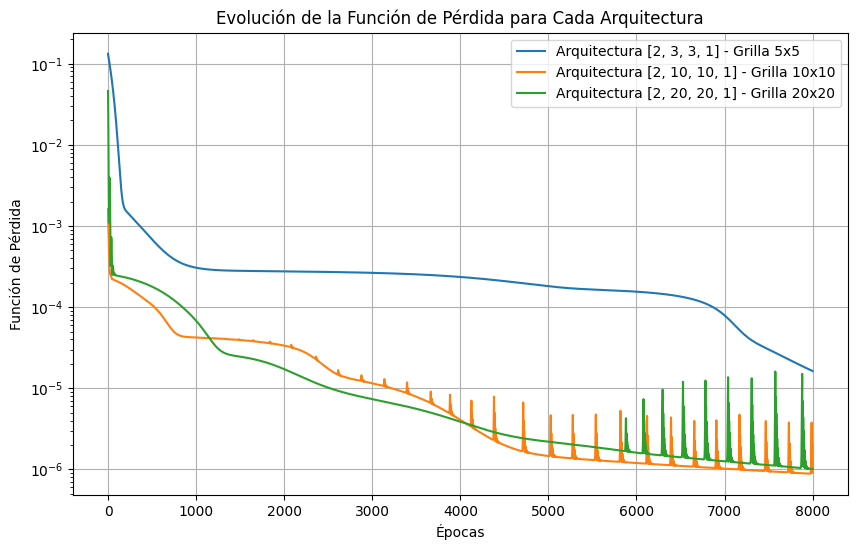

In [100]:
plt.figure(figsize=(10, 6))
for i, loss_data in enumerate(loss_history):
    epochs, losses = zip(*loss_data)  # Separar épocas y pérdidas
    plt.semilogy(epochs, losses, label=f"Arquitectura {layers[i]} - Grilla {grid_size[i]}x{grid_size[i]}")

plt.xlabel("Épocas")
plt.ylabel("Función de Pérdida")
plt.title("Evolución de la Función de Pérdida para Cada Arquitectura")
plt.legend()
plt.grid(True)
plt.show()

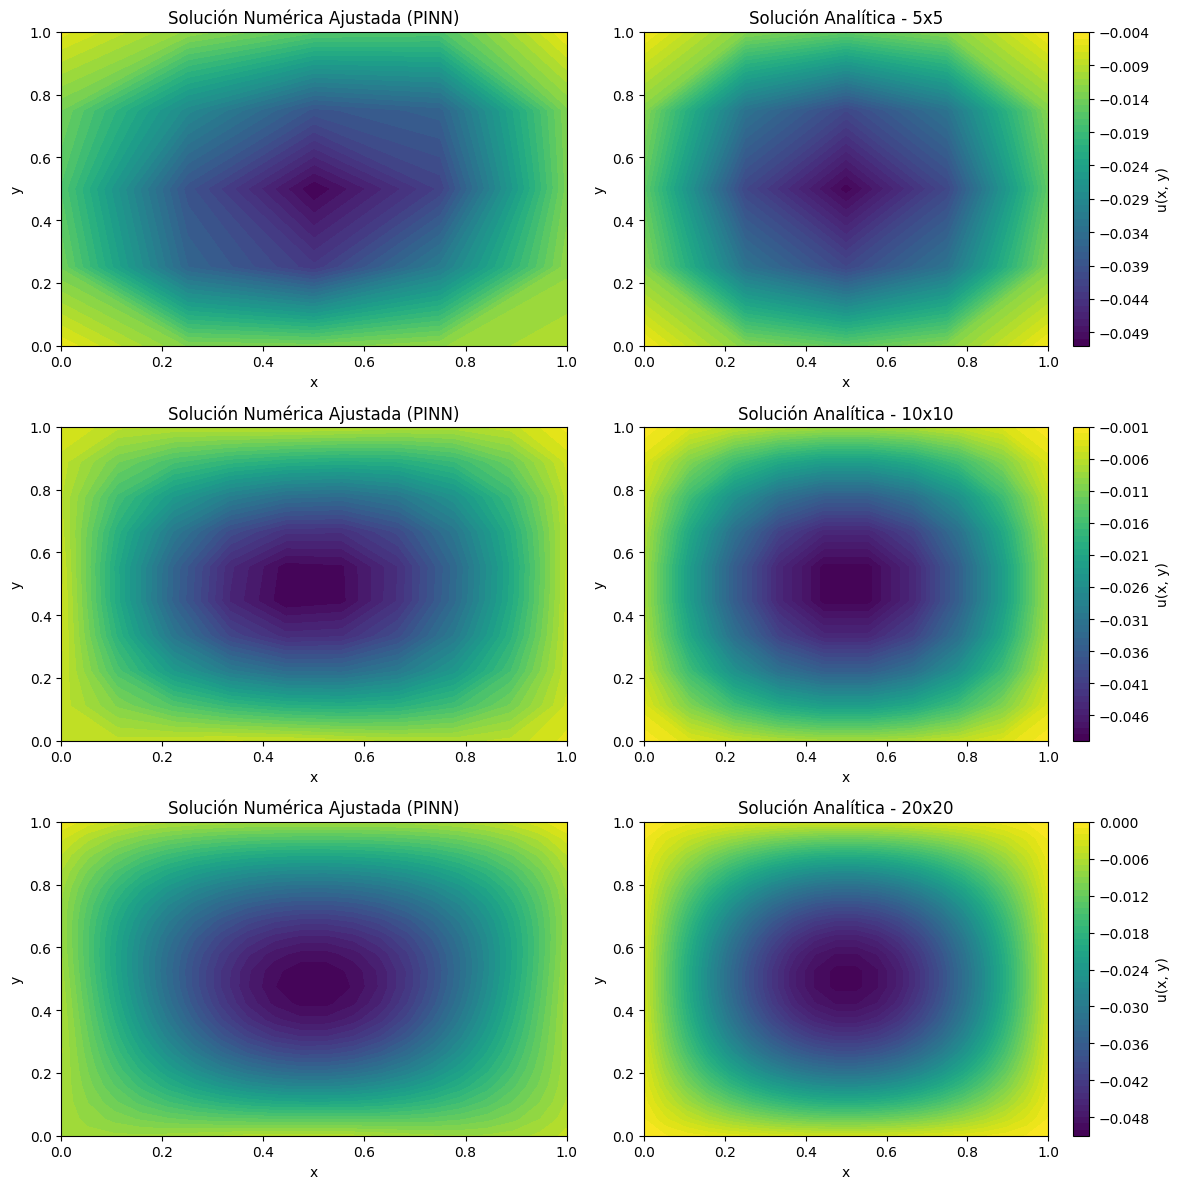

In [101]:
# Graficar resultados
fig, ax = plt.subplots(3, 2, figsize=(12, 12))
k = 0
for i in range(3):
    j = 0
    # **Recalculate X and Y for the current grid size**
    x = np.linspace(0, Lx, nx[k])  # Use Lx for x range
    y = np.linspace(0, Ly, ny[k])  # Use Ly for y range
    X, Y = np.meshgrid(x, y)

    # Solución numérica obtenida con FiPy
    contourf = ax[i,j].contourf(X, Y, u_pinn[k], levels=50, cmap="viridis")
    # Call colorbar on the figure and pass the contourf object
    ax[i,j].set_title("Solución Numérica Ajustada (PINN)")
    ax[i,j].set_xlabel("x")
    ax[i,j].set_ylabel("y")

    j += 1
    # Solución analítica
    contour = ax[i, j].contourf(
       np.reshape(u_ex[k], (ny[k], nx[k])),
      levels=50,
      cmap="viridis",
      extent=(0, Lx, 0, Ly)
    )
    fig.colorbar(contour, ax=ax[i,j], label="u(x, y)")
    ax[i,j].set_title("Solución Analítica - {}x{}".format(nx[k],ny[k]))
    ax[i,j].set_xlabel("x")
    ax[i,j].set_ylabel("y")

    k +=1

plt.tight_layout()
plt.show()

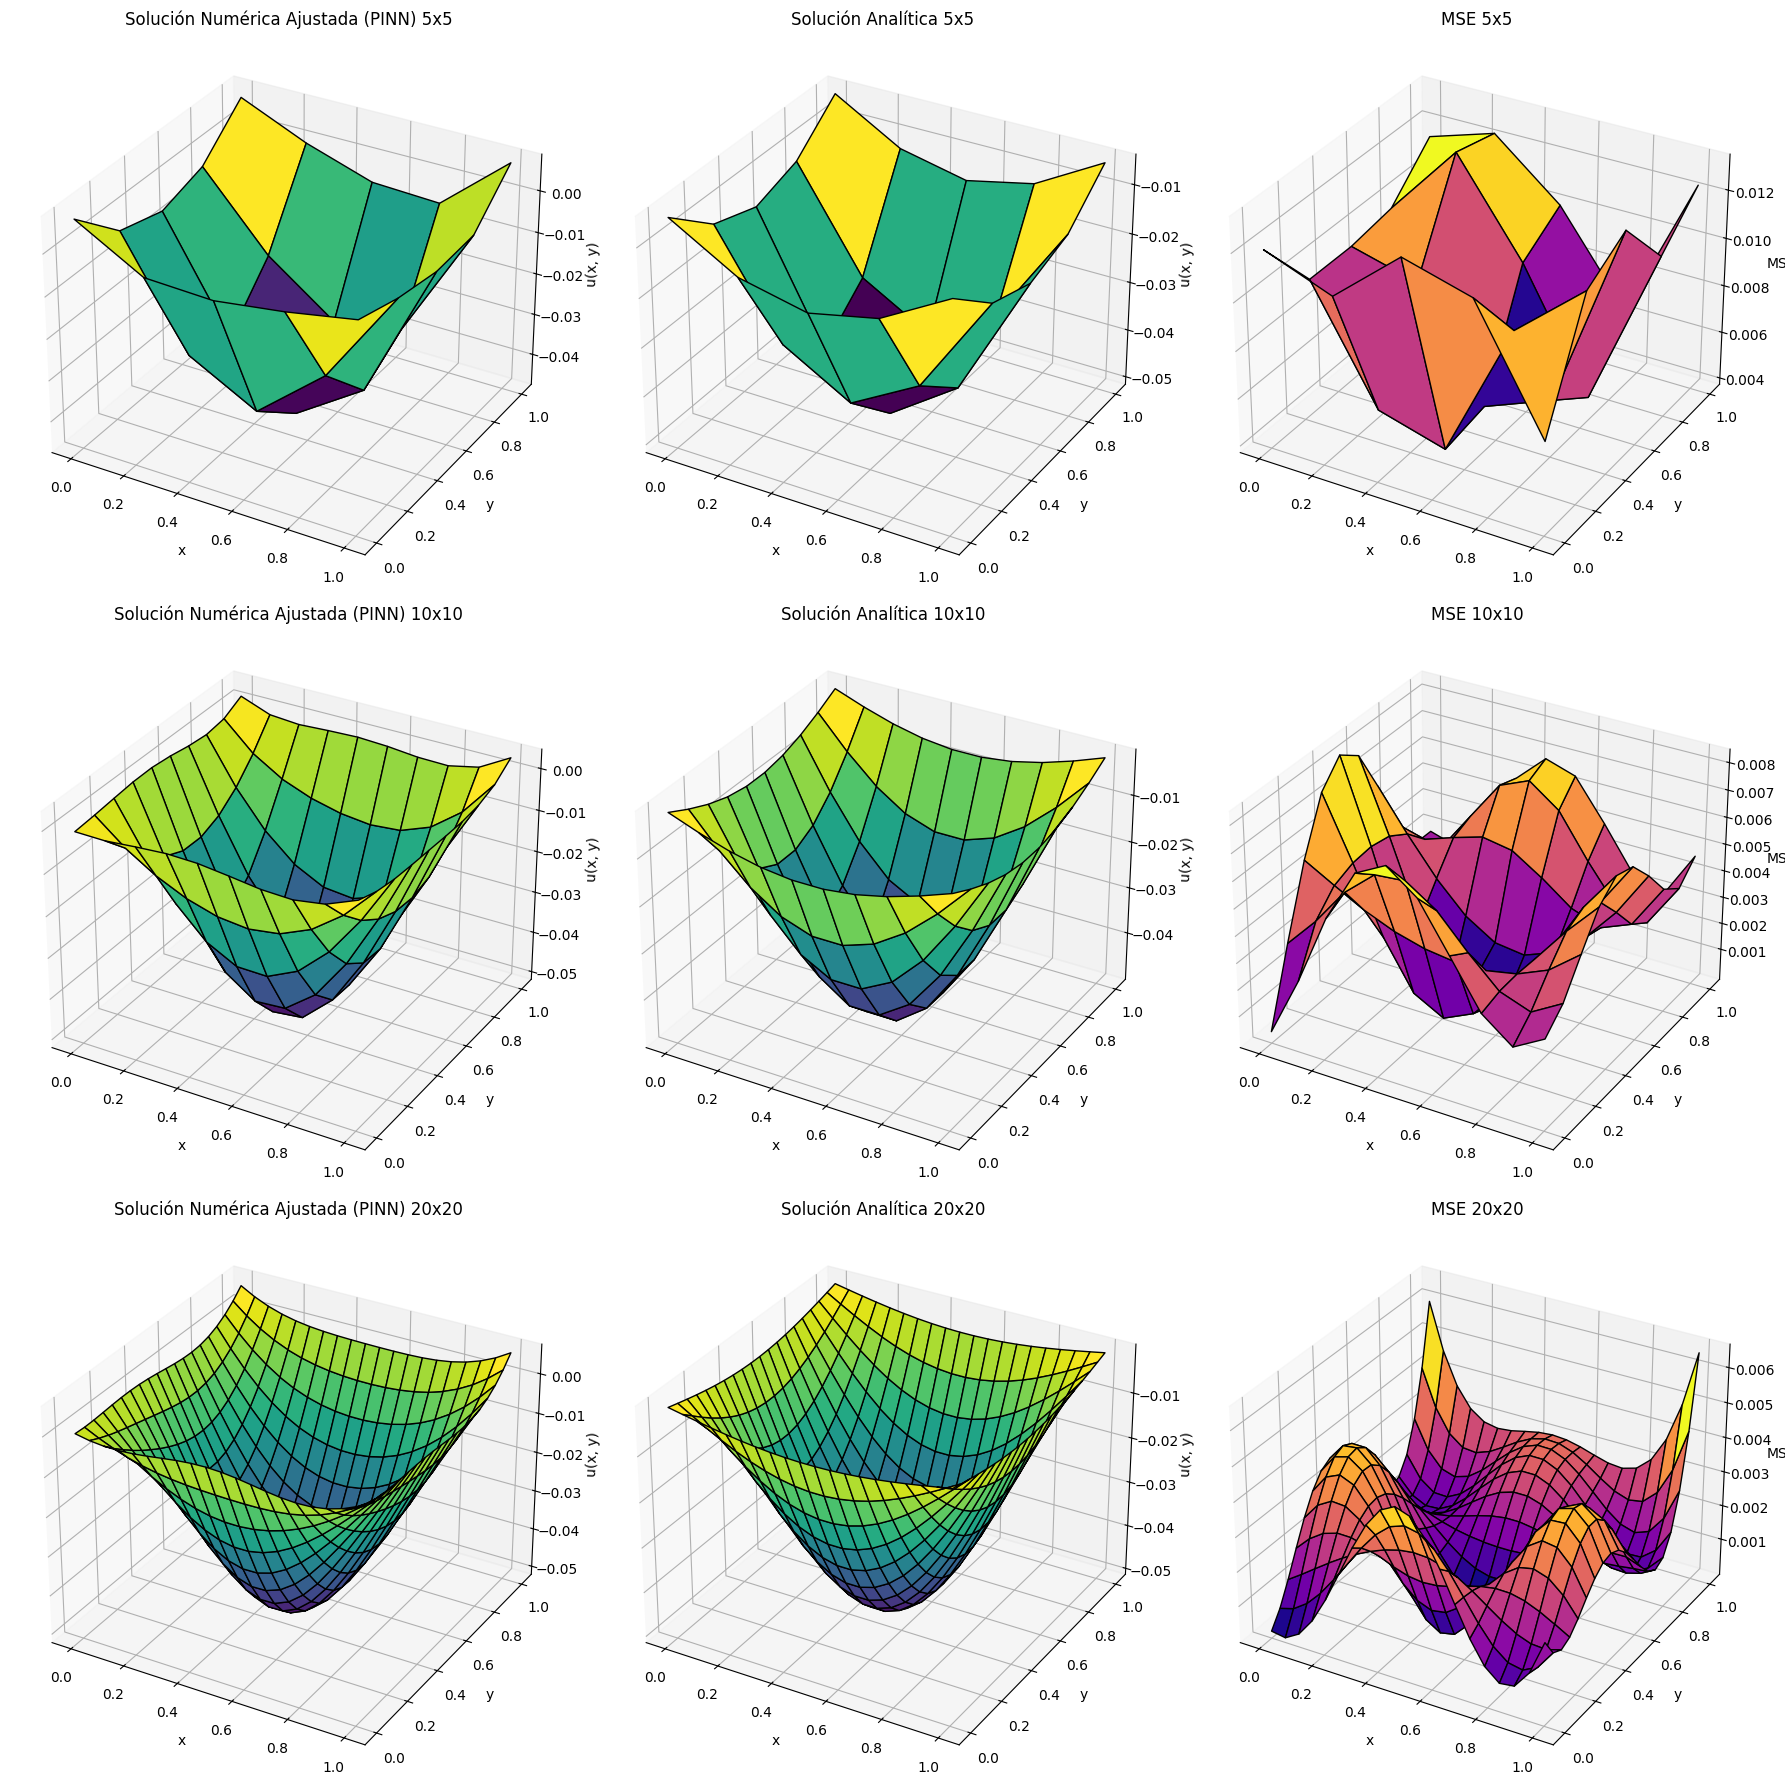

In [102]:
# Crear subgráficos para las soluciones 3D
fig = plt.figure(figsize=(18, 18))

for i in range(len(nx)):
    # Crear mallas para la grilla actual
    x_vals = np.linspace(0, Lx, nx[i])
    y_vals = np.linspace(0, Ly, ny[i])
    X, Y = np.meshgrid(x_vals, y_vals)

    # Reshape de las soluciones para gráficos 3D
    u_PINN = np.reshape(u_pinn[i], (ny[i], nx[i]))
    u_exact = np.reshape(u_ex[i], (ny[i], nx[i]))
    error_pointwise = np.sqrt((u_PINN - u_exact) ** 2)

    # Solución Numérica Ajustada (PINN)
    ax_pinn = fig.add_subplot(len(nx), 3, 3 * i + 1, projection='3d') # Changed to 3 columns and adjusted index
    ax_pinn.plot_surface(X, Y, u_PINN, cmap='viridis', edgecolor='k')
    ax_pinn.set_title(f"Solución Numérica Ajustada (PINN) {nx[i]}x{ny[i]}")
    ax_pinn.set_xlabel("x")
    ax_pinn.set_ylabel("y")
    ax_pinn.set_zlabel("u(x, y)")

    # Solución analítica
    ax_exact = fig.add_subplot(len(nx), 3, 3 * i + 2, projection='3d') # Changed to 3 columns and adjusted index
    ax_exact.plot_surface(X, Y, u_exact, cmap='viridis', edgecolor='k')
    ax_exact.set_title(f"Solución Analítica {nx[i]}x{ny[i]}")
    ax_exact.set_xlabel("x")
    ax_exact.set_ylabel("y")
    ax_exact.set_zlabel("u(x, y)")

    # MSE punto a punto
    ax_error= fig.add_subplot(len(nx), 3, 3 * i + 3, projection='3d') # Changed to 3 columns and adjusted index
    ax_error.plot_surface(X, Y, error_pointwise, cmap='plasma', edgecolor='k')
    ax_error.set_title(f"MSE {nx[i]}x{ny[i]}")
    ax_error.set_xlabel("x")
    ax_error.set_ylabel("y")
    ax_error.set_zlabel("MSE")

plt.tight_layout()
plt.show()

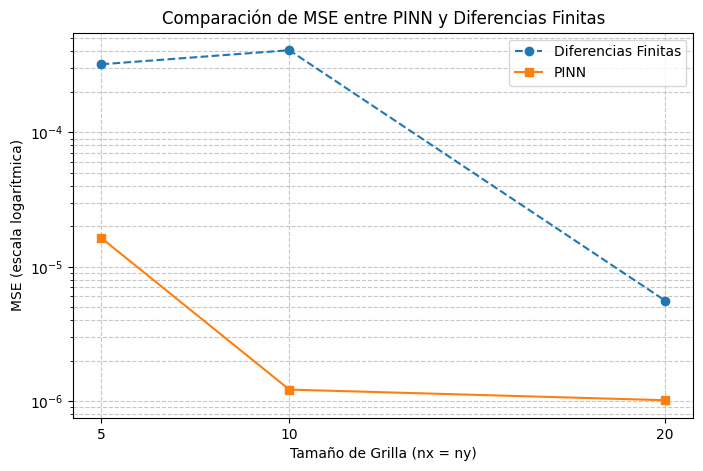

In [106]:
# Calcular MSE para PINN y Diferencias Finitas respecto a la solución exacta
mse_pinn = []
mse_numeric = []

# Assuming u_numeric is a list of solutions corresponding to grid sizes in nx and ny
for i in range(len(u_pinn)):
    # Solución exacta para la grilla correspondiente
    x = np.linspace(0, 1, nx[i])  # Use nx[i] for grid size
    y = np.linspace(0, 1, ny[i])  # Use ny[i] for grid size
    X, Y = np.meshgrid(x, y)
    u_exact = exact_solution(X, Y)

    # Calcular el MSE para PINN
    mse_pinn.append(np.mean((u_pinn[i] - u_exact) ** 2))

    # Calcular el MSE para Diferencias Finitas
    # Extract the relevant portion of u_numeric for the current grid size
    u_numeric_subset = u_numeric[0:nx[i], 0:ny[i]] # Extract a subset matching the current grid

    # Reshape is likely not needed here if u_numeric_subset is already the correct shape
    # u_numeric_reshaped = u_numeric_subset.reshape(u_exact.shape)

    mse_numeric.append(np.mean((u_numeric_subset - u_exact) ** 2))

# Gráfico comparativo con puntos y escala logarítmica en el eje Y
plt.figure(figsize=(8, 5))

grid_sizes = [5, 10, 20]  # Tamaños de las grillas
plt.semilogy(grid_sizes, mse_numeric, marker='o', linestyle='--', label="Diferencias Finitas")
plt.semilogy(grid_sizes, mse_pinn, marker='s', linestyle='-', label="PINN")

plt.xlabel("Tamaño de Grilla (nx = ny)")
plt.ylabel("MSE (escala logarítmica)")
plt.title("Comparación de MSE entre PINN y Diferencias Finitas")
plt.xticks(grid_sizes)
plt.legend()
plt.grid(which="both", linestyle="--", alpha=0.7)
plt.show()

### Problema No Lineal